In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
#from wordcloud import WordCloud

#Input data files are available in the read-only "../input/" directory
#For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import nltk
import inflect
import contractions
from bs4 import BeautifulSoup
import re, string, unicodedata
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer


In [3]:
df = pd.read_csv('tweet_emotions.csv')
df.head()

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...


In [4]:
df.shape

(40000, 3)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   40000 non-null  int64 
 1   sentiment  40000 non-null  object
 2   content    40000 non-null  object
dtypes: int64(1), object(2)
memory usage: 937.6+ KB


In [6]:
df.isnull().sum()

tweet_id     0
sentiment    0
content      0
dtype: int64

In [7]:
df.duplicated().sum()

0

In [8]:
df.drop('tweet_id', axis=1, inplace=True)

In [9]:
df['sentiment'].value_counts()

neutral       8638
worry         8459
happiness     5209
sadness       5165
love          3842
surprise      2187
fun           1776
relief        1526
hate          1323
empty          827
enthusiasm     759
boredom        179
anger          110
Name: sentiment, dtype: int64

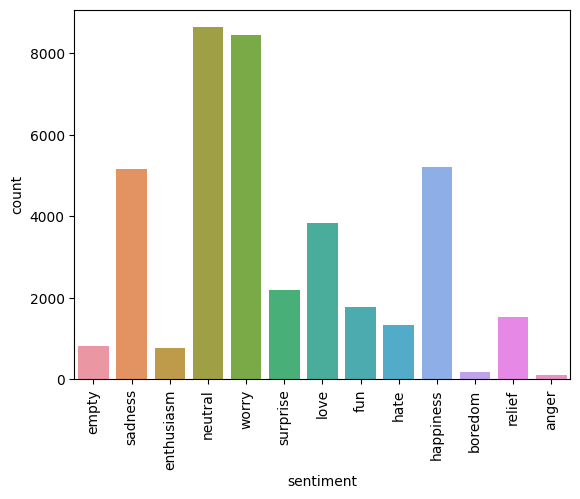

In [10]:
sns.countplot(x=df['sentiment'])
plt.xticks(rotation=90)
plt.show()

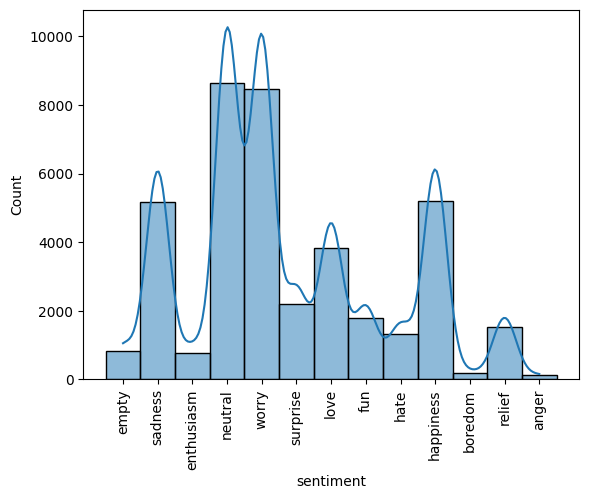

In [11]:
sns.histplot(x=df['sentiment'], kde=True)
plt.xticks(rotation=90)
plt.show()

In [12]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /home/cfm5qc/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/cfm5qc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/cfm5qc/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/cfm5qc/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [13]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

# Remove junk

In [14]:
def text_preprocessing_platform(df, text_col, remove_stopwords=True):

    ## Define functions for individual steps
    # First function is used to denoise text
    def denoise_text(text):
        # Strip html if any. For ex. removing <html>, <p> tags
        soup = BeautifulSoup(text, "html.parser")
        text = soup.get_text()
        # Replace contractions in the text. For ex. didn't -> did not
        text = contractions.fix(text)
        return text

    ## Next step is text-normalization

    # Text normalization includes many steps.

    # Each function below serves a step.


    def remove_non_ascii(words):
        """Remove non-ASCII characters from list of tokenized words"""
        new_words = []
        for word in words:
            new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
            new_words.append(new_word)
        return new_words


    def to_lowercase(words):
        """Convert all characters to lowercase from list of tokenized words"""
        new_words = []
        for word in words:
            new_word = word.lower()
            new_words.append(new_word)
        return new_words


    def remove_punctuation(words):
        """Remove punctuation from list of tokenized words"""
        new_words = []
        for word in words:
            new_word = re.sub(r'[^\w\s]', '', word)
            if new_word != '':
                new_words.append(new_word)
        return new_words


    def replace_numbers(words):
        """Replace all interger occurrences in list of tokenized words with textual representation"""
        p = inflect.engine()
        new_words = []
        for word in words:
            if word.isdigit():
                new_word = p.number_to_words(word)
                new_words.append(new_word)
            else:
                new_words.append(word)
        return new_words


    def remove_stopwords(words):
        """Remove stop words from list of tokenized words"""
        new_words = []
        for word in words:
            if word not in stopwords.words('english'):
                new_words.append(word)
        return new_words


    def stem_words(words):
        """Stem words in list of tokenized words"""
        stemmer = LancasterStemmer()
        stems = []
        for word in words:
            stem = stemmer.stem(word)
            stems.append(stem)
        return stems


    def lemmatize_verbs(words):
        """Lemmatize verbs in list of tokenized words"""
        lemmatizer = WordNetLemmatizer()
        lemmas = []
        for word in words:
            lemma = lemmatizer.lemmatize(word, pos='v')
            lemmas.append(lemma)
        return lemmas


    ### A wrap-up function for normalization
    def normalize_text(words, remove_stopwords):
        words = remove_non_ascii(words)
        words = to_lowercase(words)
        words = remove_punctuation(words)
        words = replace_numbers(words)
        if remove_stopwords:
            words = remove_stopwords(words)
        #words = stem_words(words)
        words = lemmatize_verbs(words)
        return words

    # All above functions work on word tokens we need a tokenizer

    # Tokenize tweet into words
    def tokenize(text):
        return nltk.word_tokenize(text)


    # A overall wrap-up function
    def text_prepare(text):
        text = denoise_text(text)
        text = ' '.join([x for x in normalize_text(tokenize(text), remove_stopwords)])
        return text

    # run every-step
    df[text_col] = [text_prepare(x) for x in df[text_col]]


    # return processed df
    return df

In [15]:
df = text_preprocessing_platform(df, 'content', remove_stopwords=True)

In [16]:
df.head()

,sentiment,content
0,empty,tiffanylue know listenin bad habit earlier sta...
1,sadness,layin n bed headache ughhhh waitin call
2,sadness,funeral ceremony gloomy friday
3,enthusiasm,want hang friends soon
4,neutral,dannycastillo want trade someone houston ticke...


In [17]:
df['sentiment'].value_counts()

neutral       8638
worry         8459
happiness     5209
sadness       5165
love          3842
surprise      2187
fun           1776
relief        1526
hate          1323
empty          827
enthusiasm     759
boredom        179
anger          110
Name: sentiment, dtype: int64

In [18]:
def categorize_sentiment(row):
    if row['sentiment'] in ['empty', 'sadness', 'anger', 'worry', 'hate', 'boredom']:
        return 'Concerned'
    elif row['sentiment'] in ['neutral','relief','surprise','enthusiasm', 'happiness', 'love', 'fun']:  # Note: 'empty' appears again; check if this is correct.
        return 'Neutral'
    #elif row['sentiment'] in ['enthusiasm', 'happiness', 'love', 'fun']:
    #    return 'Positive'
    #elif row['sentiment'] in ['neutral']:
       # return 'Neutral'
    else:
        return 'Undefined'  # Handle any cases that don't fit the above categories

# Apply the function along the rows of the DataFrame
df['category'] = df.apply(categorize_sentiment, axis=1)

In [19]:
#df.rename(columns={'sentiment': 'category'}, inplace=True)

In [20]:
df

,sentiment,content,category
0,empty,tiffanylue know listenin bad habit earlier sta...,Concerned
1,sadness,layin n bed headache ughhhh waitin call,Concerned
2,sadness,funeral ceremony gloomy friday,Concerned
3,enthusiasm,want hang friends soon,Neutral
4,neutral,dannycastillo want trade someone houston ticke...,Neutral
...,...,...,...
39995,neutral,johnlloydtaylor,Neutral
39996,love,happy mother day love,Neutral
39997,love,happy mother day mommies woman man long momma ...,Neutral
39998,happiness,niariley wassup beautiful follow peep new hit ...,Neutral


# Balance data

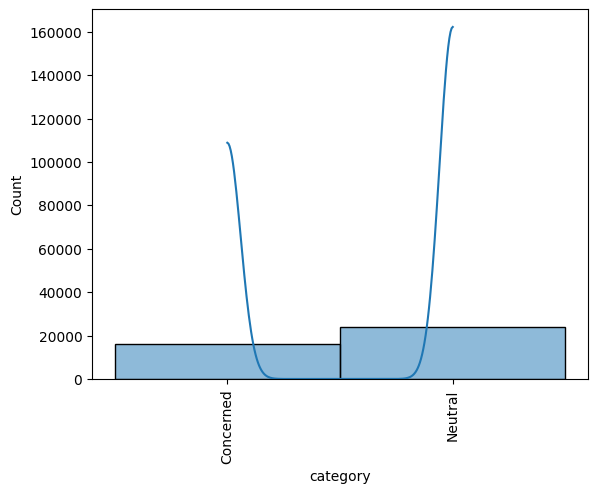

In [21]:
sns.histplot(x=df['category'], kde=True)
plt.xticks(rotation=90)
plt.show()

In [22]:
df['category'].value_counts()

Neutral      23937
Concerned    16063
Name: category, dtype: int64

In [23]:
df

,sentiment,content,category
0,empty,tiffanylue know listenin bad habit earlier sta...,Concerned
1,sadness,layin n bed headache ughhhh waitin call,Concerned
2,sadness,funeral ceremony gloomy friday,Concerned
3,enthusiasm,want hang friends soon,Neutral
4,neutral,dannycastillo want trade someone houston ticke...,Neutral
...,...,...,...
39995,neutral,johnlloydtaylor,Neutral
39996,love,happy mother day love,Neutral
39997,love,happy mother day mommies woman man long momma ...,Neutral
39998,happiness,niariley wassup beautiful follow peep new hit ...,Neutral


In [24]:
label_mapping = {'Neutral': 0, 'Concerned': 1}#, 'Concerned':2}, 'happiness': 2, 'sadness':3, 'love':4, 'surprise':5,'fun':6, 'relief':7, 'hate':8, 'empty':9,
              #  'enthusiasm':10, 'boredom':11,'anger':12}
df['category'] = df['category'].map(label_mapping)


In [25]:
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)
print(f'Train: {len(train_df)}; Test: {len(test_df)}')

Train: 28000; Test: 12000


In [26]:
train_df

,sentiment,content,category
38015,sadness,ficklampa hehe option advertise world mess mig...,1
2281,boredom,wake day need go work suck also go dentist fil...,1
36629,neutral,ilhongy would get,0
6087,worry,penbleth leave forever miss much,1
11792,neutral,lt train today ehhh hard tall hard feel good s...,0
...,...,...,...
6265,neutral,clean,0
11284,hate,ooo goddddd vodafone trouble network,1
38158,fun,watch run fat boy run haha soo funny,0
860,hate,calvinharris make pork products fuck stop impo...,1


In [27]:
X_train = train_df['content'].values
y_train = train_df['category'].values

X = test_df['content'].values
y = test_df['category'].values

test_df, val_df = train_test_split(test_df, test_size=0.25)

X_valid = val_df['content'].values
y_valid = val_df['sentiment'].values

X_test = test_df['content'].values
y_test = test_df['sentiment'].values

print(f'X_train: {len(X_train)}; X_test: {len(X_test)}; X_valid: {len(X_valid)}')
print(f'y_train: {len(y_train)}; y_test: {len(y_test)}; y_valid: {len(y_valid)}')

X_train: 28000; X_test: 9000; X_valid: 3000
y_train: 28000; y_test: 9000; y_valid: 3000


In [29]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
y_train = encoder.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_test = encoder.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()
y_valid = encoder.fit_transform(np.array(y_valid).reshape(-1, 1)).toarray()
labels = np.unique(encoder.inverse_transform(y_train))

In [30]:
labels = df['category'].unique()


In [31]:
from transformers import XLNetForSequenceClassification
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import XLNetTokenizer
from torch.utils.data import Dataset, DataLoader
from transformers import AdamW
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
import torch.nn as nn

In [32]:
def categorize_sentiment(row):
    if row['sentiment'] in ['empty', 'sadness', 'anger', 'worry', 'hate', 'boredom']:
        return 'Concerned'
    elif row['sentiment'] in ['neutral']:  # Note: 'empty' appears again; check if this is correct.
        return 'Neutral'
    elif row['sentiment'] in ['enthusiasm', 'happiness', 'love', 'fun','relief','surprise']:
        return 'Positive'
    #elif row['sentiment'] in ['neutral']:
       # return 'Neutral'
    else:
        return 'Undefined'  # Handle any cases that don't fit the above categories

# Apply the function along the rows of the DataFrame
df['category'] = df.apply(categorize_sentiment, axis=1)


In [33]:
label_mapping = {'Neutral': 0, 'Concerned': 1, 'Positive':2}# 'happiness': 2, 'sadness':3, 'love':4, 'surprise':5,'fun':6, 'relief':7, 'hate':8, 'empty':9,
              #  'enthusiasm':10, 'boredom':11,'anger':12}
df['category'] = df['category'].map(label_mapping)

In [34]:
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)
print(f'Train: {len(train_df)}; Test: {len(test_df)}')

Train: 28000; Test: 12000


In [35]:
X = test_df['content'].values
y = test_df['category'].values

test_df, val_df = train_test_split(test_df, test_size=0.25)

X_valid = val_df['content'].values
y_valid = val_df['sentiment'].values

X_test = test_df['content'].values
y_test = test_df['sentiment'].values

print(f'X_train: {len(X_train)}; X_test: {len(X_test)}; X_valid: {len(X_valid)}')
print(f'y_train: {len(y_train)}; y_test: {len(y_test)}; y_valid: {len(y_valid)}')

X_train: 28000; X_test: 9000; X_valid: 3000
y_train: 56000; y_test: 9000; y_valid: 3000


In [37]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
y_train = encoder.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_test = encoder.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()
y_valid = encoder.fit_transform(np.array(y_valid).reshape(-1, 1)).toarray()
labels = np.unique(encoder.inverse_transform(y_train))

In [38]:
labels = df['category'].unique()

In [39]:
def plot_loss_over_epochs(train_losses, val_losses):

    if len(train_losses) != len(val_losses):
        raise ValueError("train_losses and val_losses must be of the same length.")
    
    epochs = list(range(1, len(train_losses) + 1))
    
    # Create DataFrame to organize the data
    model_loss_df = pd.DataFrame({
        'Epoch': epochs,
        'Average Training Loss': train_losses,
        'Validation Loss': val_losses
    })
    
    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(model_loss_df['Epoch'], model_loss_df['Average Training Loss'], label='Average Training Loss', marker='o')
    plt.plot(model_loss_df['Epoch'], model_loss_df['Validation Loss'], label='Validation Loss', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

# Hyperparameters

## Batch Size

### 32 Batch Size and 1e-4

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Epoch 1/10


Training: 100%|██████████| 875/875 [01:35<00:00,  9.21it/s]


Training Loss: 1.0872


Validation: 100%|██████████| 94/94 [00:03<00:00, 31.29it/s]


Validation Loss: 1.0731
Epoch 2/10


Training: 100%|██████████| 875/875 [01:31<00:00,  9.60it/s]


Training Loss: 1.0769


Validation: 100%|██████████| 94/94 [00:05<00:00, 18.10it/s]


Validation Loss: 1.0748
Epoch 3/10


Training: 100%|██████████| 875/875 [01:24<00:00, 10.33it/s]


Training Loss: 1.0750


Validation: 100%|██████████| 94/94 [00:03<00:00, 27.27it/s]


Validation Loss: 1.0795
Epoch 4/10


Training: 100%|██████████| 875/875 [01:31<00:00,  9.58it/s]


Training Loss: 1.0743


Validation: 100%|██████████| 94/94 [00:03<00:00, 30.69it/s]


Validation Loss: 1.0724
Epoch 5/10


Training: 100%|██████████| 875/875 [01:28<00:00,  9.93it/s]


Training Loss: 1.0738


Validation: 100%|██████████| 94/94 [00:04<00:00, 21.75it/s]


Validation Loss: 1.0759
Epoch 6/10


Training: 100%|██████████| 875/875 [01:25<00:00, 10.18it/s]


Training Loss: 1.0707


Validation: 100%|██████████| 94/94 [00:03<00:00, 28.30it/s]


Validation Loss: 1.0728
Epoch 7/10


Training: 100%|██████████| 875/875 [01:21<00:00, 10.76it/s]


Training Loss: 1.0696


Validation: 100%|██████████| 94/94 [00:04<00:00, 19.59it/s]


Validation Loss: 1.0747
Epoch 8/10


Training: 100%|██████████| 875/875 [01:25<00:00, 10.26it/s]


Training Loss: 1.0695


Validation: 100%|██████████| 94/94 [00:04<00:00, 23.34it/s]


Validation Loss: 1.0775
Epoch 9/10


Training: 100%|██████████| 875/875 [01:15<00:00, 11.58it/s]


Training Loss: 1.0687


Validation: 100%|██████████| 94/94 [00:06<00:00, 15.29it/s]


Validation Loss: 1.0783
Epoch 10/10


Training: 100%|██████████| 875/875 [01:22<00:00, 10.61it/s]


Training Loss: 1.0686


Validation: 100%|██████████| 94/94 [00:05<00:00, 17.46it/s]


Validation Loss: 1.0775
Validation Set Evaluation:
Confusion Matrix:
[[   0  684    0]
 [   0 1196    0]
 [   0 1120    0]]
Classification Report:
              precision    recall  f1-score   support

     Neutral       0.00      0.00      0.00       684
   Concerned       0.40      1.00      0.57      1196
    Positive       0.00      0.00      0.00      1120

    accuracy                           0.40      3000
   macro avg       0.13      0.33      0.19      3000
weighted avg       0.16      0.40      0.23      3000



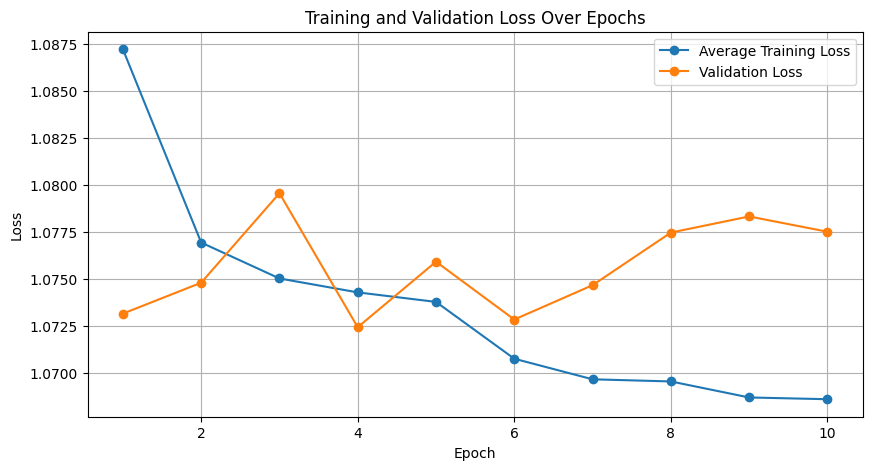

In [40]:
model_name = 'xlnet-base-cased'
tokenizer = XLNetTokenizer.from_pretrained(model_name)
model = XLNetForSequenceClassification.from_pretrained(model_name, num_labels=5)
is_train=True
from sklearn.preprocessing import LabelEncoder

# Initialize the label encoder
label_encoder = LabelEncoder()

# Fit and transform the categories to numerical labels
train_df['category'] = label_encoder.fit_transform(train_df['category'])
test_df['category'] = label_encoder.transform(test_df['category'])
val_df['category'] = label_encoder.transform(val_df['category'])

# Now the categories are numerical, you can convert them to tensors
y_train = torch.tensor(train_df['category'].values)
y_test = torch.tensor(test_df['category'].values)
y_valid = torch.tensor(val_df['category'].values)

# Tokenize and preprocess the text data
def tokenize_text(text):
    tokens = tokenizer.encode(text, add_special_tokens=True, padding=True, truncation=True)
    return tokens

train_df['TokenizedText'] = train_df['content'].apply(tokenize_text)
test_df['TokenizedText'] = test_df['content'].apply(tokenize_text)
val_df['TokenizedText'] = val_df['content'].apply(tokenize_text)

# Convert tokenized data to PyTorch tensors with padding
X_train = pad_sequence([torch.tensor(seq) for seq in train_df['TokenizedText']], batch_first=True)
y_train = torch.tensor(train_df['category'].tolist())
X_test = pad_sequence([torch.tensor(seq) for seq in test_df['TokenizedText']], batch_first=True)
y_test = torch.tensor(test_df['category'].tolist())
X_valid = pad_sequence([torch.tensor(seq) for seq in val_df['TokenizedText']], batch_first=True)
y_valid = torch.tensor(val_df['category'].tolist())

# Define a DataLoader for batching data
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=32)
val_dataset = TensorDataset(X_valid, y_valid)
val_dataloader = DataLoader(val_dataset, batch_size=32)

# Define the training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

training_loss = []
validation_loss = [] 

def train(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for inputs, labels in tqdm(dataloader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs, labels=labels)  # Assuming your model takes 'labels' during training
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)
    return avg_loss

# Define the validation loop
def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Validation"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.logits, labels)
            total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)
    return avg_loss

def evaluate(model, dataloader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.logits, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, target_names=label_mapping.keys())
    return cm, report

# Number of epochs
num_epochs = 10

# Epoch loop
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train_loss = train(model, train_dataloader, optimizer, criterion, device)
    print(f"Training Loss: {train_loss:.4f}")
    training_loss.append(train_loss)
    val_loss = validate(model, val_dataloader, criterion, device)
    print(f"Validation Loss: {val_loss:.4f}")
    validation_loss.append(val_loss)

valid_cm, valid_report = evaluate(model, val_dataloader)
print("Validation Set Evaluation:")
print("Confusion Matrix:")
print(valid_cm)
print("Classification Report:")
print(valid_report)

plot_loss_over_epochs(training_loss, validation_loss)

### 32 Batch Size and 1e-6

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Epoch 1/10


Training: 100%|██████████| 875/875 [01:36<00:00,  9.07it/s]


Training Loss: 1.0960


Validation: 100%|██████████| 94/94 [00:07<00:00, 12.24it/s]


Validation Loss: 0.9577
Epoch 2/10


Training: 100%|██████████| 875/875 [01:31<00:00,  9.55it/s]


Training Loss: 0.9569


Validation: 100%|██████████| 94/94 [00:06<00:00, 13.43it/s]


Validation Loss: 0.9033
Epoch 3/10


Training: 100%|██████████| 875/875 [01:30<00:00,  9.66it/s]


Training Loss: 0.9186


Validation: 100%|██████████| 94/94 [00:07<00:00, 12.23it/s]


Validation Loss: 0.9286
Epoch 4/10


Training: 100%|██████████| 875/875 [01:32<00:00,  9.51it/s]


Training Loss: 0.9037


Validation: 100%|██████████| 94/94 [00:05<00:00, 16.08it/s]


Validation Loss: 0.8907
Epoch 5/10


Training: 100%|██████████| 875/875 [01:29<00:00,  9.82it/s]


Training Loss: 0.8919


Validation: 100%|██████████| 94/94 [00:04<00:00, 19.44it/s]


Validation Loss: 0.8996
Epoch 6/10


Training: 100%|██████████| 875/875 [01:25<00:00, 10.19it/s]


Training Loss: 0.8841


Validation: 100%|██████████| 94/94 [00:03<00:00, 27.76it/s]


Validation Loss: 0.8925
Epoch 7/10


Training: 100%|██████████| 875/875 [01:32<00:00,  9.46it/s]


Training Loss: 0.8724


Validation: 100%|██████████| 94/94 [00:06<00:00, 15.20it/s]


Validation Loss: 0.9003
Epoch 8/10


Training: 100%|██████████| 875/875 [01:33<00:00,  9.40it/s]


Training Loss: 0.8665


Validation: 100%|██████████| 94/94 [00:05<00:00, 16.88it/s]


Validation Loss: 0.8822
Epoch 9/10


Training: 100%|██████████| 875/875 [01:33<00:00,  9.33it/s]


Training Loss: 0.8595


Validation: 100%|██████████| 94/94 [00:06<00:00, 15.65it/s]


Validation Loss: 0.8800
Epoch 10/10


Training: 100%|██████████| 875/875 [01:35<00:00,  9.16it/s]


Training Loss: 0.8552


Validation: 100%|██████████| 94/94 [00:06<00:00, 15.48it/s]


Validation Loss: 0.8850
Validation Set Evaluation:
Confusion Matrix:
[[273 227 184]
 [157 832 207]
 [126 245 749]]
Classification Report:
              precision    recall  f1-score   support

     Neutral       0.49      0.40      0.44       684
   Concerned       0.64      0.70      0.67      1196
    Positive       0.66      0.67      0.66      1120

    accuracy                           0.62      3000
   macro avg       0.60      0.59      0.59      3000
weighted avg       0.61      0.62      0.61      3000



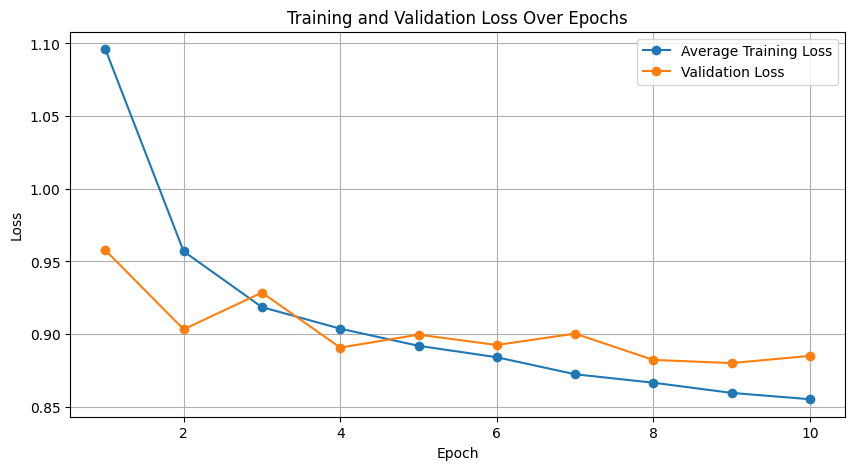

In [41]:
model_name = 'xlnet-base-cased'
tokenizer = XLNetTokenizer.from_pretrained(model_name)
model = XLNetForSequenceClassification.from_pretrained(model_name, num_labels=5)
is_train=True
from sklearn.preprocessing import LabelEncoder

# Initialize the label encoder
label_encoder = LabelEncoder()

# Fit and transform the categories to numerical labels
train_df['category'] = label_encoder.fit_transform(train_df['category'])
test_df['category'] = label_encoder.transform(test_df['category'])
val_df['category'] = label_encoder.transform(val_df['category'])

# Now the categories are numerical, you can convert them to tensors
y_train = torch.tensor(train_df['category'].values)
y_test = torch.tensor(test_df['category'].values)
y_valid = torch.tensor(val_df['category'].values)

# Tokenize and preprocess the text data
def tokenize_text(text):
    tokens = tokenizer.encode(text, add_special_tokens=True, padding=True, truncation=True)
    return tokens

train_df['TokenizedText'] = train_df['content'].apply(tokenize_text)
test_df['TokenizedText'] = test_df['content'].apply(tokenize_text)
val_df['TokenizedText'] = val_df['content'].apply(tokenize_text)

# Convert tokenized data to PyTorch tensors with padding
X_train = pad_sequence([torch.tensor(seq) for seq in train_df['TokenizedText']], batch_first=True)
y_train = torch.tensor(train_df['category'].tolist())
X_test = pad_sequence([torch.tensor(seq) for seq in test_df['TokenizedText']], batch_first=True)
y_test = torch.tensor(test_df['category'].tolist())
X_valid = pad_sequence([torch.tensor(seq) for seq in val_df['TokenizedText']], batch_first=True)
y_valid = torch.tensor(val_df['category'].tolist())

# Define a DataLoader for batching data
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=32)
val_dataset = TensorDataset(X_valid, y_valid)
val_dataloader = DataLoader(val_dataset, batch_size=32)

# Define the training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-6)
criterion = nn.CrossEntropyLoss()

training_loss = []
validation_loss = [] 

def train(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for inputs, labels in tqdm(dataloader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs, labels=labels)  # Assuming your model takes 'labels' during training
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)
    return avg_loss

def evaluate(model, dataloader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.logits, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, target_names=label_mapping.keys())
    return cm, report

# Define the validation loop
def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Validation"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.logits, labels)
            total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)
    return avg_loss
# Number of epochs
num_epochs = 10

# Epoch loop
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train_loss = train(model, train_dataloader, optimizer, criterion, device)
    print(f"Training Loss: {train_loss:.4f}")
    training_loss.append(train_loss)
    val_loss = validate(model, val_dataloader, criterion, device)
    print(f"Validation Loss: {val_loss:.4f}")
    validation_loss.append(val_loss)

valid_cm, valid_report = evaluate(model, val_dataloader)
print("Validation Set Evaluation:")
print("Confusion Matrix:")
print(valid_cm)
print("Classification Report:")
print(valid_report)

plot_loss_over_epochs(training_loss, validation_loss)

### 32 Batch Size and 1e-8

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Epoch 1/10


Training: 100%|██████████| 875/875 [01:20<00:00, 10.92it/s]


Training Loss: 1.5319


Validation: 100%|██████████| 94/94 [00:06<00:00, 14.36it/s]


Validation Loss: 1.4467
Epoch 2/10


Training: 100%|██████████| 875/875 [01:35<00:00,  9.13it/s]


Training Loss: 1.4405


Validation: 100%|██████████| 94/94 [00:03<00:00, 25.04it/s]


Validation Loss: 1.3672
Epoch 3/10


Training: 100%|██████████| 875/875 [01:36<00:00,  9.10it/s]


Training Loss: 1.3603


Validation: 100%|██████████| 94/94 [00:07<00:00, 12.26it/s]


Validation Loss: 1.3011
Epoch 4/10


Training: 100%|██████████| 875/875 [01:30<00:00,  9.62it/s]


Training Loss: 1.2991


Validation: 100%|██████████| 94/94 [00:05<00:00, 18.59it/s]


Validation Loss: 1.2498
Epoch 5/10


Training: 100%|██████████| 875/875 [01:27<00:00, 10.01it/s]


Training Loss: 1.2520


Validation: 100%|██████████| 94/94 [00:04<00:00, 21.03it/s]


Validation Loss: 1.2120
Epoch 6/10


Training: 100%|██████████| 875/875 [01:33<00:00,  9.35it/s]


Training Loss: 1.2193


Validation: 100%|██████████| 94/94 [00:03<00:00, 26.41it/s]


Validation Loss: 1.1848
Epoch 7/10


Training: 100%|██████████| 875/875 [01:35<00:00,  9.16it/s]


Training Loss: 1.1897


Validation: 100%|██████████| 94/94 [00:06<00:00, 13.98it/s]


Validation Loss: 1.1640
Epoch 8/10


Training: 100%|██████████| 875/875 [01:31<00:00,  9.56it/s]


Training Loss: 1.1746


Validation: 100%|██████████| 94/94 [00:08<00:00, 11.62it/s]


Validation Loss: 1.1486
Epoch 9/10


Training: 100%|██████████| 875/875 [01:33<00:00,  9.31it/s]


Training Loss: 1.1588


Validation: 100%|██████████| 94/94 [00:06<00:00, 14.52it/s]


Validation Loss: 1.1364
Epoch 10/10


Training: 100%|██████████| 875/875 [01:48<00:00,  8.04it/s]


Training Loss: 1.1487


Validation: 100%|██████████| 94/94 [00:08<00:00, 11.31it/s]


Validation Loss: 1.1272
Validation Set Evaluation:
Confusion Matrix:
[[  0 453 231]
 [  0 779 417]
 [  0 644 476]]
Classification Report:
              precision    recall  f1-score   support

     Neutral       0.00      0.00      0.00       684
   Concerned       0.42      0.65      0.51      1196
    Positive       0.42      0.42      0.42      1120

    accuracy                           0.42      3000
   macro avg       0.28      0.36      0.31      3000
weighted avg       0.32      0.42      0.36      3000



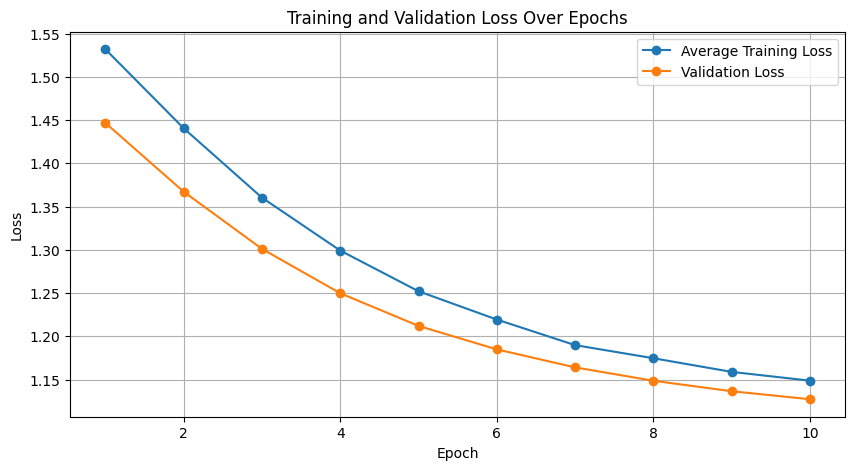

In [42]:
model_name = 'xlnet-base-cased'
tokenizer = XLNetTokenizer.from_pretrained(model_name)
model = XLNetForSequenceClassification.from_pretrained(model_name, num_labels=5)
is_train=True
from sklearn.preprocessing import LabelEncoder

# Initialize the label encoder
label_encoder = LabelEncoder()

# Fit and transform the categories to numerical labels
train_df['category'] = label_encoder.fit_transform(train_df['category'])
test_df['category'] = label_encoder.transform(test_df['category'])
val_df['category'] = label_encoder.transform(val_df['category'])

# Now the categories are numerical, you can convert them to tensors
y_train = torch.tensor(train_df['category'].values)
y_test = torch.tensor(test_df['category'].values)
y_valid = torch.tensor(val_df['category'].values)

# Tokenize and preprocess the text data
def tokenize_text(text):
    tokens = tokenizer.encode(text, add_special_tokens=True, padding=True, truncation=True)
    return tokens

train_df['TokenizedText'] = train_df['content'].apply(tokenize_text)
test_df['TokenizedText'] = test_df['content'].apply(tokenize_text)
val_df['TokenizedText'] = val_df['content'].apply(tokenize_text)

# Convert tokenized data to PyTorch tensors with padding
X_train = pad_sequence([torch.tensor(seq) for seq in train_df['TokenizedText']], batch_first=True)
y_train = torch.tensor(train_df['category'].tolist())
X_test = pad_sequence([torch.tensor(seq) for seq in test_df['TokenizedText']], batch_first=True)
y_test = torch.tensor(test_df['category'].tolist())
X_valid = pad_sequence([torch.tensor(seq) for seq in val_df['TokenizedText']], batch_first=True)
y_valid = torch.tensor(val_df['category'].tolist())

# Define a DataLoader for batching data
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=32)
val_dataset = TensorDataset(X_valid, y_valid)
val_dataloader = DataLoader(val_dataset, batch_size=32)

# Define the training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-8)
criterion = nn.CrossEntropyLoss()

training_loss = []
validation_loss = [] 

def train(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for inputs, labels in tqdm(dataloader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs, labels=labels)  # Assuming your model takes 'labels' during training
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)
    return avg_loss

# Define the validation loop
def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Validation"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.logits, labels)
            total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)
    return avg_loss

def evaluate(model, dataloader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.logits, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, target_names=label_mapping.keys())
    return cm, report

# Number of epochs
num_epochs = 10

# Epoch loop
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train_loss = train(model, train_dataloader, optimizer, criterion, device)
    print(f"Training Loss: {train_loss:.4f}")
    training_loss.append(train_loss)
    val_loss = validate(model, val_dataloader, criterion, device)
    print(f"Validation Loss: {val_loss:.4f}")
    validation_loss.append(val_loss)

valid_cm, valid_report = evaluate(model, val_dataloader)
print("Validation Set Evaluation:")
print("Confusion Matrix:")
print(valid_cm)
print("Classification Report:")
print(valid_report)

plot_loss_over_epochs(training_loss, validation_loss)